In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/MDD/Alzheimer Detection')
print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/MDD/Alzheimer Detection


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, SeparableConv2D, BatchNormalization, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

### Defining Train and Test Paths

In [4]:
BASE_DIR = "Alzheimer_Dataset/"
TRAIN_DIR = BASE_DIR + 'train'
TEST_DIR = BASE_DIR + 'test'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
DIM = (IMG_SIZE, IMG_SIZE)

### Generating Data using DataGenerator

In [5]:
datagen = IDG(
    rescale = 1./255,
    brightness_range=[0.8, 1.2],
    zoom_range=[.99, 1.01],
    data_format="channels_last",
    fill_mode='constant',
    horizontal_flip=True
)

train_data_gen = datagen.flow_from_directory(directory=TRAIN_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 2614 images belonging to 4 classes.


### Retrieving features and labels

In [6]:
#Retrieving the data from the ImageDataGenerator iterator
train_data, train_labels = train_data_gen.next()

#Getting to know the dimensions of our dataset
print(train_data.shape, train_labels.shape)

(2614, 176, 176, 3) (2614, 4)


### Splitting Train Test Data

In [7]:
#Splitting the data into train, test, and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(train_data,
                                                                  train_labels,
                                                                  test_size = 0.2,
                                                                  random_state=42)

In [9]:
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.utils import plot_model
# import matplotlib.pyplot as plt
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications import VGG16
# def conv_block(filters, act='relu'):
#     """Defining a Convolutional NN block for a Sequential CNN model. """

#     block = Sequential()
#     block.add(Conv2D(filters, 3, activation=act, padding='same'))
#     block.add(Conv2D(filters, 3, activation=act, padding='same'))
#     block.add(BatchNormalization())
#     block.add(MaxPool2D())

#     return block

# def dense_block(units, dropout_rate, act='relu'):
#     """Defining a Dense NN block for a Sequential CNN model. """

#     block = Sequential()
#     block.add(Dense(units, activation=act))
#     block.add(BatchNormalization())
#     block.add(Dropout(dropout_rate))

#     return block

# def construct_model(act='relu'):
#     """Constructing a Sequential CNN architecture for performing the classification task. """

#     model = Sequential([
#         Input(shape=(*[IMG_SIZE,IMG_SIZE], 3)),
#         Conv2D(16, 3, activation=act, padding='same'),
#         Conv2D(16, 3, activation=act, padding='same'),
#         MaxPool2D(),
#         conv_block(32),
#         conv_block(64),
#         conv_block(128),
#         Dropout(0.2),
#         conv_block(256),
#         Dropout(0.2),
#         Flatten(),
#         dense_block(512, 0.7),
#         dense_block(128, 0.5),
#         dense_block(64, 0.3),
#         Dense(4, activation='softmax')
#     ], name = "cnn_model")

#     return model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def conv_block(inputs, filters, act='relu'):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    x = Conv2D(filters, 3, activation=act, padding='same')(inputs)
    x = Conv2D(filters, 3, activation=act, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    return x

def dense_block(inputs, units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    x = Dense(units, activation=act)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    return x

def construct_model(act='relu', img_size=176):
    """Constructing a Sequential CNN architecture for performing the classification task. """

    inputs = Input(shape=(img_size, img_size, 3))

    # Initial Convolutional Block
    x = Conv2D(16, 3, activation=act, padding='same')(inputs)
    x = Conv2D(16, 3, activation=act, padding='same')(x)
    x = MaxPooling2D()(x)
    skip1 = x  # Skip connection 1

    # Conv Block 2
    x = conv_block(x, 32, act)
    x = MaxPooling2D()(x)
    skip2 = x  # Skip connection 2

    # Conv Block 3 with Dilation
    x = conv_block(x, 64, act)
    x = MaxPooling2D()(x)
    skip3 = x  # Skip connection 3

    # Conv Block 4 with Dilation
    x = conv_block(x, 128, act)
    x = Dropout(0.2)(x)
    x = MaxPooling2D()(x)

    # Adding skip connections
    skip3 = Conv2D(128, 1, activation=act, padding='same')(skip3)  # Match channels
    x = Add()([x, skip3])  # Add skip connection 3

    x = conv_block(x, 256, act)
    x = Dropout(0.2)(x)

    # Flatten and Dense Layers
    x = Flatten()(x)
    x = dense_block(x, 512, 0.7, act)
    x = dense_block(x, 128, 0.5, act)
    x = dense_block(x, 64, 0.3, act)
    outputs = Dense(4, activation='softmax')(x)

    model = Model(inputs, outputs, name="cnn_model_with_skip_connections")

    return model

# Define model parameters
IMG_SIZE = 176
METRICS = ['accuracy']

# Construct the model
model = construct_model(img_size=IMG_SIZE)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=METRICS)

# Summary of the model
model.summary()



Model: "cnn_model_with_skip_connections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 176, 176, 3)]        0         []                            
                                                                                                  
 conv2d_57 (Conv2D)          (None, 176, 176, 16)         448       ['input_7[0][0]']             
                                                                                                  
 conv2d_58 (Conv2D)          (None, 176, 176, 16)         2320      ['conv2d_57[0][0]']           
                                                                                                  
 max_pooling2d_27 (MaxPooli  (None, 88, 88, 16)           0         ['conv2d_58[0][0]']           
 ng2D)                                                              

### Defining MyCallback class

It says that when on the end of an epoch, the val accuracy crosses 0.99 stop the training.

In [10]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True

my_callback = MyCallback()
CALLBACKS = [my_callback]

Model: "cnn_model_with_skip_connections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 176, 176, 3)]        0         []                            
                                                                                                  
 conv2d_68 (Conv2D)          (None, 176, 176, 16)         448       ['input_8[0][0]']             
                                                                                                  
 conv2d_69 (Conv2D)          (None, 176, 176, 16)         2320      ['conv2d_68[0][0]']           
                                                                                                  
 max_pooling2d_35 (MaxPooli  (None, 88, 88, 16)           0         ['conv2d_69[0][0]']           
 ng2D)                                                              

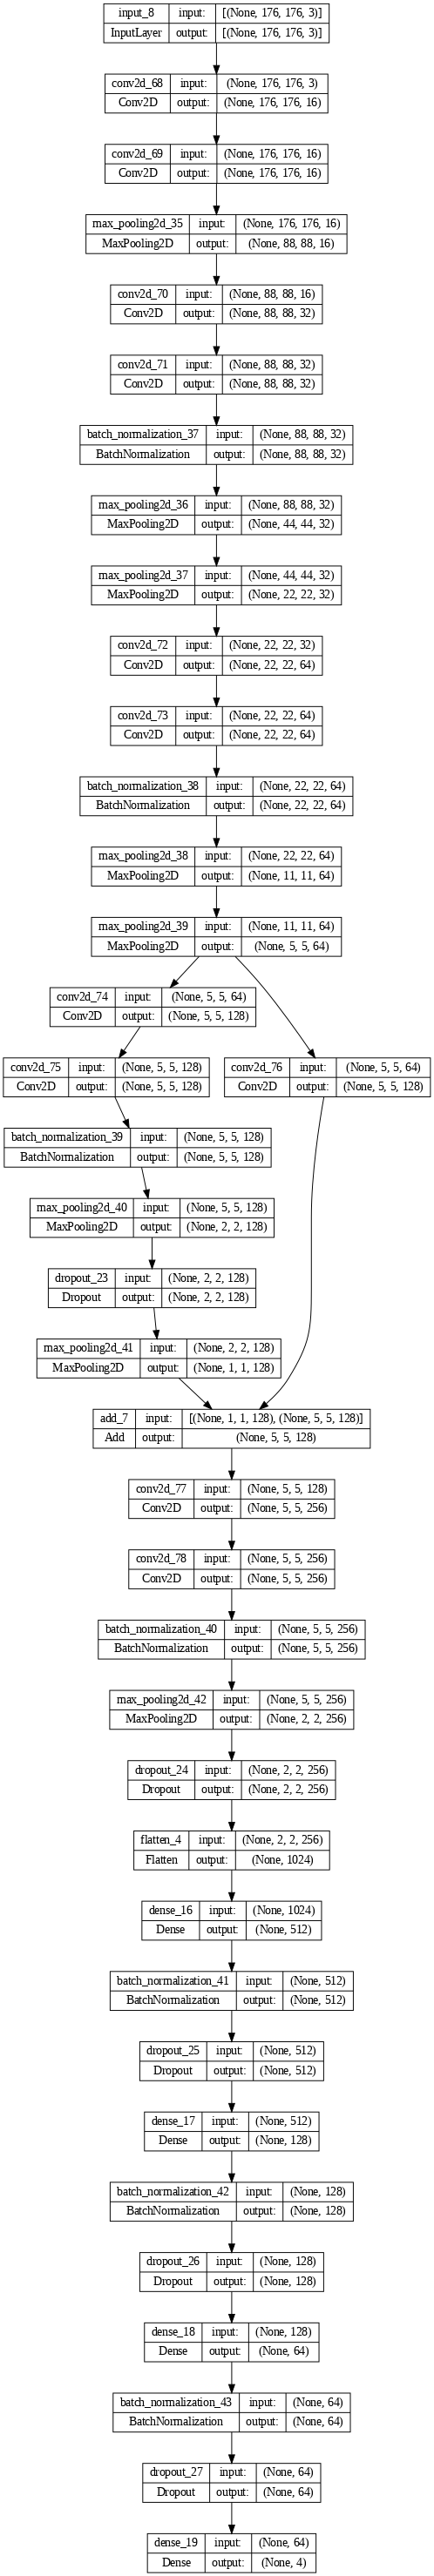

In [11]:
model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]



model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=70, expand_nested=False)

Model: "cnn_model_with_skip_and_dilation"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 176, 176, 3)]        0         []                            
                                                                                                  
 conv2d_46 (Conv2D)          (None, 176, 176, 16)         448       ['input_6[0][0]']             
                                                                                                  
 conv2d_47 (Conv2D)          (None, 176, 176, 16)         2320      ['conv2d_46[0][0]']           
                                                                                                  
 max_pooling2d_22 (MaxPooli  (None, 88, 88, 16)           0         ['conv2d_47[0][0]']           
 ng2D)                                                             

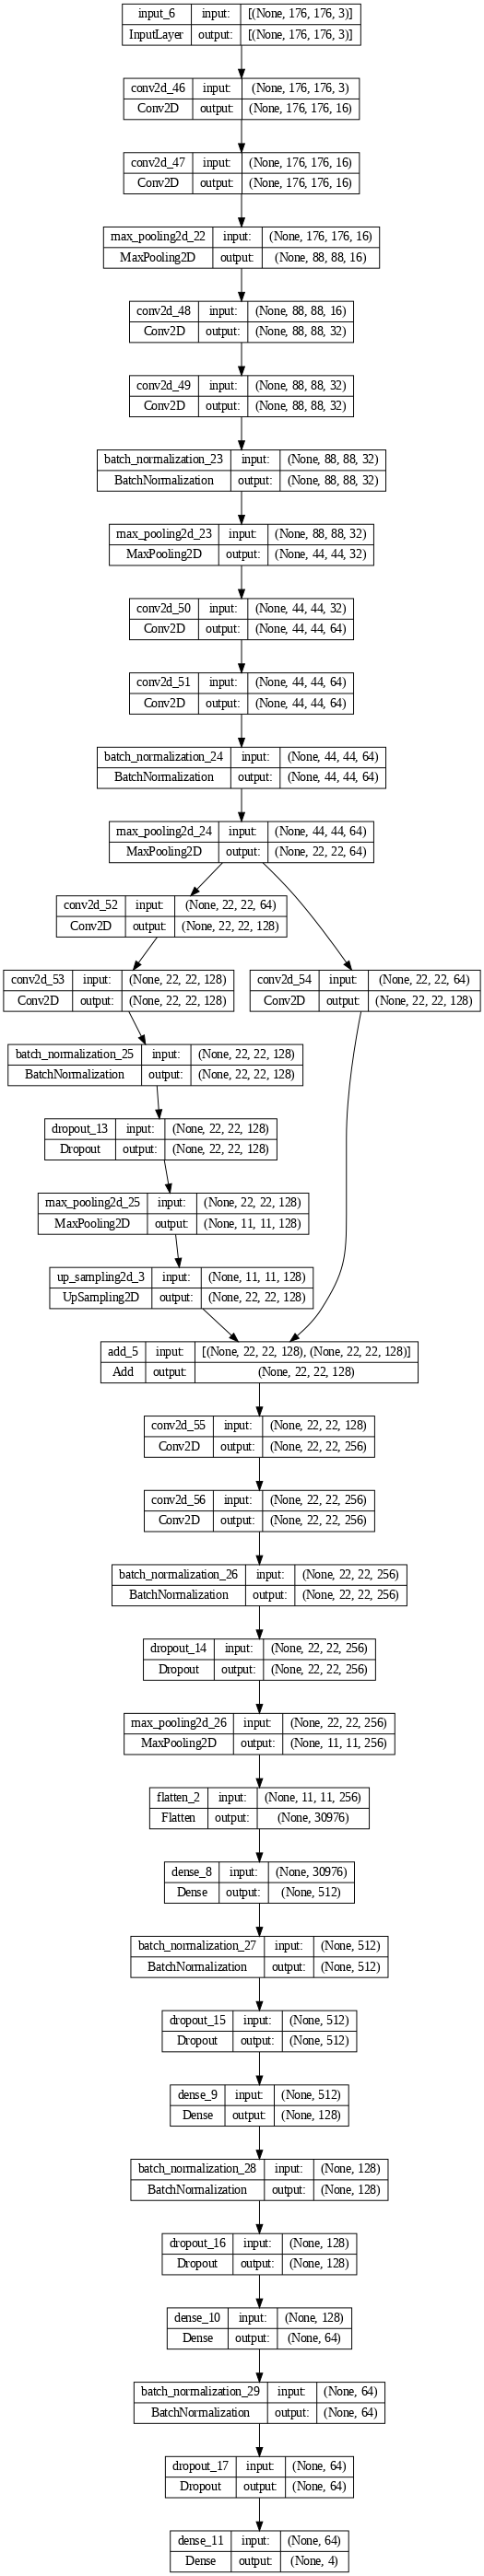

In [8]:
from tensorflow.keras.layers import Input, Add, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, UpSampling2D
from tensorflow.keras.models import Model

def conv_block(inputs, filters, act='relu', dilation_rate=1):
    """Defining a Convolutional NN block with optional dilation. """
    x = Conv2D(filters, 3, activation=act, padding='same', dilation_rate=dilation_rate)(inputs)
    x = Conv2D(filters, 3, activation=act, padding='same', dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    return x

def dense_block(inputs, units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    x = Dense(units, activation=act)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    return x

def construct_model(act='relu', img_size=176):
    """Constructing a Sequential CNN architecture for performing the classification task with skip connections and dilated convolutions. """

    inputs = Input(shape=(img_size, img_size, 3))

    # Initial Convolutional Block
    x = Conv2D(16, 3, activation=act, padding='same')(inputs)
    x = Conv2D(16, 3, activation=act, padding='same')(x)
    x = MaxPooling2D()(x)
    skip1 = x  # Skip connection 1

    # Conv Block 2
    x = conv_block(x, 32, act)
    x = MaxPooling2D()(x)
    skip2 = x  # Skip connection 2

    # Conv Block 3 with Dilation
    x = conv_block(x, 64, act, dilation_rate=2)
    x = MaxPooling2D()(x)
    skip3 = x  # Skip connection 3

    # Conv Block 4 with Dilation
    x = conv_block(x, 128, act, dilation_rate=4)
    x = Dropout(0.2)(x)
    x = MaxPooling2D()(x)

    # Adding skip connections
    skip3 = Conv2D(128, 1, activation=act, padding='same')(skip3)  # Match channels
    x = UpSampling2D(size=(2, 2))(x)  # Upsample to match skip3 dimensions
    x = Add()([x, skip3])  # Add skip connection 3

    x = conv_block(x, 256, act)
    x = Dropout(0.2)(x)
    x = MaxPooling2D()(x)

    # Flatten and Dense Layers
    x = Flatten()(x)
    x = dense_block(x, 512, 0.7, act)
    x = dense_block(x, 128, 0.5, act)
    x = dense_block(x, 64, 0.3, act)
    outputs = Dense(4, activation='softmax')(x)

    model = Model(inputs, outputs, name="cnn_model_with_skip_and_dilation")

    return model

# Define model parameters
IMG_SIZE = 176
METRICS = ['accuracy']

# Construct the model
model = construct_model(img_size=IMG_SIZE)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=METRICS)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=70, expand_nested=False)


In [11]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 40

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)
model.save('../models/alzheimer_model.h5')

Epoch 1/40
66/66 [==============================] - 280s 4s/step - loss: 1.9224 - acc: 0.3022 - auc: 0.5466 - val_loss: 1.4832 - val_acc: 0.3556 - val_auc: 0.5695
Epoch 2/40
66/66 [==============================] - 268s 4s/step - loss: 1.5573 - acc: 0.3525 - auc: 0.6138 - val_loss: 2.9093 - val_acc: 0.3671 - val_auc: 0.5104
Epoch 3/40
66/66 [==============================] - 271s 4s/step - loss: 1.2627 - acc: 0.4577 - auc: 0.7313 - val_loss: 5.5403 - val_acc: 0.3671 - val_auc: 0.5119
Epoch 4/40
66/66 [==============================] - 260s 4s/step - loss: 1.1686 - acc: 0.4868 - auc: 0.7690 - val_loss: 10.7641 - val_acc: 0.3671 - val_auc: 0.5781
Epoch 5/40
66/66 [==============================] - 264s 4s/step - loss: 1.0873 - acc: 0.5218 - auc: 0.7928 - val_loss: 3.0556 - val_acc: 0.3805 - val_auc: 0.6635
Epoch 6/40
66/66 [==============================] - 264s 4s/step - loss: 1.0410 - acc: 0.5390 - auc: 0.8080 - val_loss: 3.1351 - val_acc: 0.3728 - val_auc: 0.6694
Epoch 7/40
66/66 [===

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model
saved_model_path = '/content/drive/MyDrive/MDD/models/alzheimer_model.h5'
history = load_model(saved_model_path)

### Plot model performance


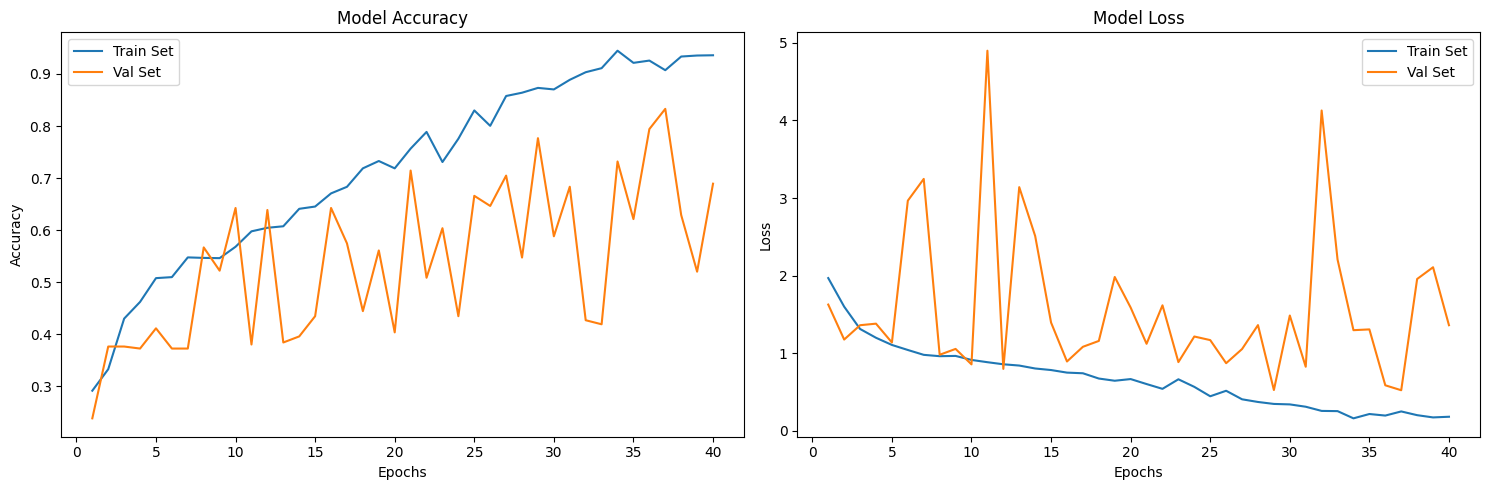

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

### Predicting the test data

In [17]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory containing your test data
test_data_dir = TEST_DIR

# Define ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)  # You can add more preprocessing if needed

# Load test data from the directory
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(176, 176),  # Set the size according to your model input shape
    batch_size=32,  # Set the batch size
    class_mode='categorical',  # Set the class mode according to your problem (e.g., binary, categorical)
    shuffle=False  # Ensure the order remains consistent for predictions
)

# Make predictions using the loaded model
pred_labels = model.predict(test_generator)


Found 713 images belonging to 4 classes.
 1/23 [>.............................] - ETA: 34s

KeyboardInterrupt: 

### Plot the confusion matrix to understand the classification in detail

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)


NameError: name 'pred_labels' is not defined

Found 626 images belonging to 4 classes.
20/20 [==============================] - 27s 1s/step


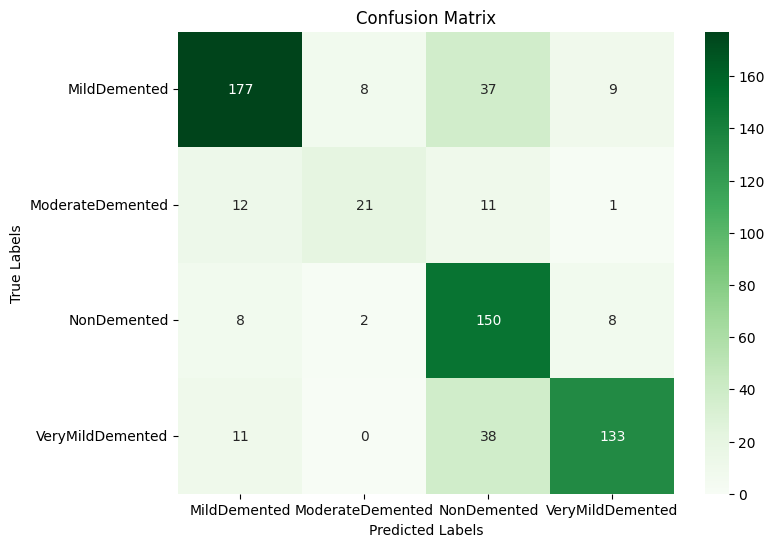

In [24]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory containing your test data
test_data_dir = TEST_DIR  # Assuming TEST_DIR is the path to your test data directory

# Define ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)  # You can add more preprocessing if needed

# Load test data from the directory
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(176, 176),  # Set the size according to your model input shape
    batch_size=32,  # Set the batch size
    class_mode='categorical',  # Set the class mode according to your problem (e.g., binary, categorical)
    shuffle=False  # Ensure the order remains consistent for predictions
)

# Make predictions using the loaded model
pred_labels = model.predict(test_generator)

# Get class labels from the generator
CLASSES = list(test_generator.class_indices.keys())

# Plotting the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Extract true labels from the generator
test_labels = test_generator.classes

# Extract predicted labels
pred_labels = np.argmax(pred_labels, axis=1)

# Create confusion matrix
conf_arr = confusion_matrix(test_labels, pred_labels)

# Plotting
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [26]:
# Calculate accuracy
from sklearn.metrics import accuracy_score

# Get true labels from the generator
true_labels = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_labels, pred_labels)

print("Accuracy on test data:", accuracy)


Accuracy on test data: 0.768370607028754
